In [ ]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#arquivo de dados
df = pd.read_csv("dataset.csv")

casas_sem_preco = df[df['Price'].isnull()].copy()

# Mapeamento dos códigos para nomes completos
mapa_tipo = {
    'h': 'Casa',
    'u': 'Apartamento',
    't': 'Terreno'
}

# renomear as colunas para português
df.rename(columns={
    'Suburb': 'Subúrbio',
    'Address': 'Endereço',
    'Rooms': 'Salas',
    'Type': 'Tipo',
    'Price': 'Preço',
    'Method': 'Método de Venda',
    'SellerG': 'Vendedor',
    'Date': 'Data',
    'Distance': 'Distância',
    'Postcode': 'Código Postal',
    'Bedroom2': 'Quartos',
    'Bathroom': 'Banheiros',
    'Car': 'Garagem',
    'Landsize': 'Tamanho do Terreno',
    'BuildingArea': 'Área Construída',
    'YearBuilt': 'Ano de Construção',
    'CouncilArea': 'Área Administrativa',
    'Lattitude': 'Latitude',
    'Longtitude': 'Longitude',
    'Regionname': 'Nome da Região',
    'Propertycount': 'Quantidade de Imóveis na Região'
}, inplace=True)

df['Tipo'] = df['Tipo'].map(mapa_tipo)

#feito para não ter que treinar toda vez que utilizar a interface
df_para_csv = df.copy()
df_para_csv = df_para_csv.drop(columns=['Vendedor', 'Data', 'Método de Venda', 'Área Administrativa', 'Nome da Região'])

display(df_para_csv.head())

,Subúrbio,Endereço,Salas,Tipo,Preço,Distância,Código Postal,Quartos,Banheiros,Garagem,Tamanho do Terreno,Área Construída,Ano de Construção,Latitude,Longitude,Quantidade de Imóveis na Região
0,Abbotsford,68 Studley St,2,Casa,NaN,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,-37.8014,144.9958,4019.0
1,Abbotsford,85 Turner St,2,Casa,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,-37.7996,144.9984,4019.0
2,Abbotsford,25 Bloomburg St,2,Casa,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0
3,Abbotsford,18/659 Victoria St,3,Apartamento,NaN,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,-37.8114,145.0116,4019.0
4,Abbotsford,5 Charles St,3,Casa,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0


In [4]:
def dados_estatisticos(df):
    print("\nFormato do DataFrame (linhas, colunas):", df.shape)
    print("\nNúmero total de linhas completas:", df.dropna().shape[0])
    print("\nColunas com valores ausentes (ordem decrescente):")
    print(df.isnull().sum().sort_values(ascending=False))

    print("\nEstatísticas descritivas para colunas numéricas:")
    print(df.describe())


    print("\nFrequência relativa das colunas categóricas :")
    for col in df.select_dtypes(include='object').columns:
        print(f"\n{col}:")
        print(df[col].value_counts(normalize=True).head(10))
    
    if 'Preço' in df.columns:
        print("\nCorrelação com a coluna 'Preço':")
        print(df.corr(numeric_only=True)['Preço'].sort_values(ascending=False))

        print("\n Histograma da variável 'Preço':")
        df['Preço'].hist(bins=50)
        plt.xlabel("Preço")
        plt.ylabel("Frequência")
        plt.title("Distribuição de Preços")
        plt.grid(True)
        plt.show()
        

    print("\n Total de linhas duplicadas:", df.duplicated().sum())
    

#display(dados_estatisticos(df))


# Contar quantos NaN existem por bairro
df_nan_garagem = df[df['Garagem'].isnull()]
nan_garagem_por_bairro = df_nan_garagem.groupby('Subúrbio').size().sort_values(ascending=False)
#print(nan_garagem_por_bairro)


In [6]:
# como visto anteriormente, dados ausentes podem afetar a análise, então é importante tratá-los
# Área Construída, Ano de Construção e Área Administrativa são colunas com muitos valores ausentes
df.drop(columns=['Área Construída', 'Ano de Construção', 'Área Administrativa', 'Vendedor'], inplace=True)
#df = df.dropna(subset=['Preço'])


#Colunas como garagem, banheiros e quartos podem ser preenchidos com a mediana, separados por bairro 
def preencher_por_bairro(df, col):
    # mediana da coluna por bairro
    mediana_por_bairro = df.groupby('Subúrbio')[col].median()

    # Função auxiliar que preenche com a mediana do bairro ou com a mediana global
    def preencher(row):
        if pd.isna(row[col]):
            bairro = row['Subúrbio']
            # se o bairro não está no índice ou a mediana é NaN, usa a mediana global PODE ALTERAR RESULTADOS
            if bairro in mediana_por_bairro and not pd.isna(mediana_por_bairro[bairro]):
                return mediana_por_bairro[bairro]
            else:
                return df[col].median()
        else:
            return row[col]

    df[col] = df.apply(preencher, axis=1)
    return df

preencher_por_bairro(df, 'Garagem')
preencher_por_bairro(df, 'Banheiros')
preencher_por_bairro(df, 'Quartos')
df['Subúrbio'].value_counts().head(60)


#display(df)

Subúrbio
Reservoir            844
Bentleigh East       583
Richmond             552
Glen Iris            491
Preston              485
Kew                  467
Brighton             456
Brunswick            444
South Yarra          435
Hawthorn             428
Northcote            424
Camberwell           423
Balwyn North         420
Essendon             409
Coburg               405
Glenroy              400
Brighton East        393
Pascoe Vale          378
St Kilda             374
Port Melbourne       371
Malvern East         369
Prahran              336
Thornbury            322
Bentleigh            319
Balwyn               319
Yarraville           304
Surrey Hills         293
Elwood               288
Moonee Ponds         285
Hawthorn East        284
Hampton              281
Toorak               278
Carnegie             277
Footscray            263
Doncaster            257
Craigieburn          255
Newport              251
Ascot Vale           249
Brunswick West       247
Mount Waverley  

In [8]:
# dataframe com preços
df_com_preco = df[df['Preço'].notna()].copy()
display(df_com_preco.count())

# dados para treinar o modelo (X) e dados que queremos prever (y) ------ SERVE PARA RF E XGBOOST
colunas_para_remover = ['Preço', 'Endereço', 'Data']
X = df_com_preco.drop(columns=colunas_para_remover, errors='ignore')
y = df_com_preco['Preço']

# Codificar categorias
X = pd.get_dummies(X, drop_first=True)

#preencher nan com a mediana
X = X.fillna(X.median(numeric_only=True))

# separa treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de Random Forest
modelo = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1, max_depth=30, bootstrap=True, min_samples_split=5, min_samples_leaf=2)
modelo.fit(X_train, y_train)


Subúrbio                           27247
Endereço                           27247
Salas                              27247
Tipo                               27247
Preço                              27247
Método de Venda                    27247
Data                               27247
Distância                          27246
Código Postal                      27246
Quartos                            27247
Banheiros                          27247
Garagem                            27247
Tamanho do Terreno                 17982
Latitude                           20993
Longitude                          20993
Nome da Região                     27244
Quantidade de Imóveis na Região    27244
dtype: int64

,n_estimators,300
,criterion,'squared_error'
,max_depth,30
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
# Previsão para o conjunto de teste
y_pred = modelo.predict(X_test)

# Calcular erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(y_test, y_pred)

print(f"Erro Absoluto Médio (MAE): R$ {mae:,.2f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")


Erro Absoluto Médio (MAE): R$ 169,157.13
R² (Coeficiente de Determinação): 0.7798


In [20]:
# Calcular o erro percentual
erro_percentual = abs((y_test - y_pred) / y_test) * 100

comparacao = pd.DataFrame({
    'Preço Real': y_test,
    'Preço Previsto': y_pred,
    'Erro Absoluto': abs(y_test - y_pred),
    'Erro Percentual': erro_percentual
})

comparacao['Preço Real'] = comparacao['Preço Real'].apply(lambda x: f'R$ {x:,.2f}')
comparacao['Preço Previsto'] = comparacao['Preço Previsto'].apply(lambda x: f'R$ {x:,.2f}')
comparacao['Erro Absoluto'] = comparacao['Erro Absoluto'].apply(lambda x: f'R$ {x:,.2f}')
comparacao['Erro Percentual'] = comparacao['Erro Percentual'].apply(lambda x: f'{x:,.2f}%')

print(comparacao.head(10))



            Preço Real   Preço Previsto  Erro Absoluto Erro Percentual
31223    R$ 855,000.00    R$ 936,488.69   R$ 81,488.69           9.53%
5620     R$ 421,000.00    R$ 405,963.31   R$ 15,036.69           3.57%
8829     R$ 800,000.00  R$ 1,013,743.58  R$ 213,743.58          26.72%
20804  R$ 1,725,000.00  R$ 1,730,833.36    R$ 5,833.36           0.34%
13829  R$ 1,345,000.00  R$ 1,258,133.09   R$ 86,866.91           6.46%
31656    R$ 611,000.00    R$ 598,082.27   R$ 12,917.73           2.11%
1895     R$ 835,000.00  R$ 1,310,296.51  R$ 475,296.51          56.92%
32816    R$ 840,000.00    R$ 766,307.42   R$ 73,692.58           8.77%
6527     R$ 560,000.00    R$ 618,923.10   R$ 58,923.10          10.52%
6743     R$ 360,000.00    R$ 513,470.88  R$ 153,470.88          42.63%


[0]	validation_0-rmse:632422.88732
[10]	validation_0-rmse:469401.82507
[20]	validation_0-rmse:386041.39050
[30]	validation_0-rmse:341043.92076
[40]	validation_0-rmse:318947.11831
[50]	validation_0-rmse:307579.79454
[60]	validation_0-rmse:301415.33233
[70]	validation_0-rmse:298056.26529
[80]	validation_0-rmse:296417.98818
[90]	validation_0-rmse:294888.20599
[100]	validation_0-rmse:293693.79759
[110]	validation_0-rmse:293037.17591
[120]	validation_0-rmse:292453.61533
[130]	validation_0-rmse:292064.34821
[140]	validation_0-rmse:291661.92326
[150]	validation_0-rmse:291285.73351
[160]	validation_0-rmse:290999.83307
[170]	validation_0-rmse:290383.83226
[180]	validation_0-rmse:289998.19795
[190]	validation_0-rmse:289760.43584
[199]	validation_0-rmse:289576.45511

Resultados do XGBoost:
Erro Absoluto Médio (MAE): R$ 162,241.59
R² (Coeficiente de Determinação): 0.8038

Comparação com Random Forest:
MAE (XGBoost): R$ 162,241.59 vs MAE (RF): R$ 169,157.13
R² (XGBoost): 0.8038 vs R² (RF): 0.7798


<Figure size 1000x800 with 0 Axes>

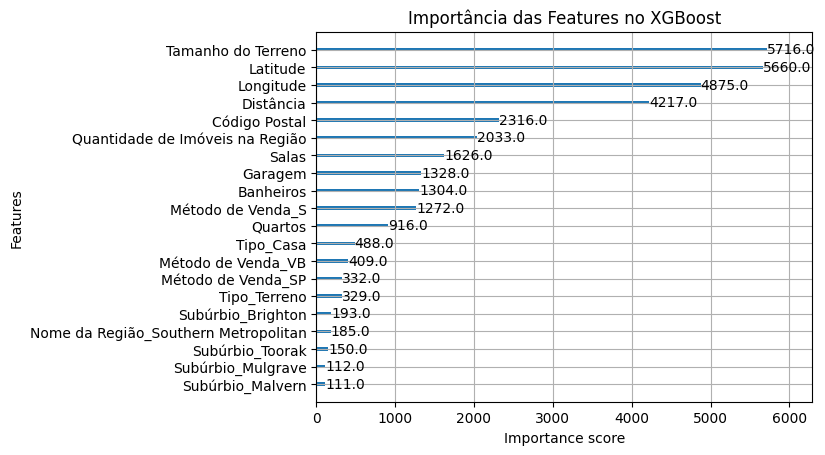


Comparação entre Random Forest e XGBoost:


,Preço Real,Preço Previsto (RF),Preço Previsto (XGBoost),Erro Absoluto (RF),Erro Absoluto (XGBoost),Erro Percentual (RF),Erro Percentual (XGBoost)
31223,"R$ 855,000.00","R$ 936,488.69","R$ 889,830.12","R$ 81,488.69","R$ 34,830.12",9.53%,4.07%
5620,"R$ 421,000.00","R$ 405,963.31","R$ 396,839.59","R$ 15,036.69","R$ 24,160.41",3.57%,5.74%
8829,"R$ 800,000.00","R$ 1,013,743.58","R$ 1,158,453.12","R$ 213,743.58","R$ 358,453.12",26.72%,44.81%
20804,"R$ 1,725,000.00","R$ 1,730,833.36","R$ 1,675,664.75","R$ 5,833.36","R$ 49,335.25",0.34%,2.86%
13829,"R$ 1,345,000.00","R$ 1,258,133.09","R$ 1,405,752.88","R$ 86,866.91","R$ 60,752.88",6.46%,4.52%
31656,"R$ 611,000.00","R$ 598,082.27","R$ 633,479.19","R$ 12,917.73","R$ 22,479.19",2.11%,3.68%
1895,"R$ 835,000.00","R$ 1,310,296.51","R$ 1,285,165.00","R$ 475,296.51","R$ 450,165.00",56.92%,53.91%
32816,"R$ 840,000.00","R$ 766,307.42","R$ 798,087.69","R$ 73,692.58","R$ 41,912.31",8.77%,4.99%
6527,"R$ 560,000.00","R$ 618,923.10","R$ 608,693.44","R$ 58,923.10","R$ 48,693.44",10.52%,8.70%
6743,"R$ 360,000.00","R$ 513,470.88","R$ 519,486.16","R$ 153,470.88","R$ 159,486.16",42.63%,44.30%



Métricas Agregadas:
MAE Random Forest: R$ 169,157.13
MAE XGBoost: R$ 162,241.59
R² Random Forest: 0.7798
R² XGBoost: 0.8038


In [21]:
#modelo random forest ja feito, agora usar xgboost
xgb_model = xgb.XGBRegressor(
    n_estimators=200,  # Número de árvores (pode ajustar)
    learning_rate=0.05,  # Taxa de aprendizado
    max_depth=10,        # Profundidade máxima das árvores
    min_child_weight=5, # Peso mínimo necessário em um nó
    subsample=0.8,      # Fração de amostras usadas para cada árvore
    colsample_bytree=0.8, # Fração de features usadas para cada árvore
    random_state=42,
    n_jobs=-1,          # Usar todos os núcleos do processador
    early_stopping_rounds=50
)



# treinar
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],  verbose=10)  # Mostrar progresso a cada 10 iterações

# resultados xgboost
y_pred_xgb = xgb_model.predict(X_test)

# estatisticas
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
erro_percentual_xgb = abs((y_test - y_pred_xgb) / y_test) * 100


print("\nResultados do XGBoost:")
print(f"Erro Absoluto Médio (MAE): R$ {mae_xgb:,.2f}")
print(f"R² (Coeficiente de Determinação): {r2_xgb:.4f}")

# comparação com Random Forest
print("\nComparação com Random Forest:")
print(f"MAE (XGBoost): R$ {mae_xgb:,.2f} vs MAE (RF): R$ {mae:,.2f}")
print(f"R² (XGBoost): {r2_xgb:.4f} vs R² (RF): {r2:.4f}")

# importancia de cada coluna xgboost
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title('Importância das Features no XGBoost')
plt.show()


# DataFrame de comparação para XGBoost
comparacao_xgb = pd.DataFrame({
    'Preço Real': y_test,
    'Preço Previsto (XGBoost)': y_pred_xgb,
    'Erro Absoluto (XGBoost)': abs(y_test - y_pred_xgb),
    'Erro Percentual (XGBoost)': erro_percentual_xgb
})

comparacao_xgb['Preço Real'] = comparacao_xgb['Preço Real'].apply(lambda x: f'R$ {x:,.2f}')
comparacao_xgb['Preço Previsto (XGBoost)'] = comparacao_xgb['Preço Previsto (XGBoost)'].apply(lambda x: f'R$ {x:,.2f}')
comparacao_xgb['Erro Absoluto (XGBoost)'] = comparacao_xgb['Erro Absoluto (XGBoost)'].apply(lambda x: f'R$ {x:,.2f}')
comparacao_xgb['Erro Percentual (XGBoost)'] = comparacao_xgb['Erro Percentual (XGBoost)'].apply(lambda x: f'{x:,.2f}%')

comparacao_xgb['Preço Previsto (RF)'] = comparacao['Preço Previsto']
comparacao_xgb['Erro Absoluto (RF)'] = comparacao['Erro Absoluto']
comparacao_xgb['Erro Percentual (RF)'] = comparacao['Erro Percentual']

# Reordenar colunas para melhor visualização
colunas_ordenadas = [
    'Preço Real',
    'Preço Previsto (RF)',
    'Preço Previsto (XGBoost)',
    'Erro Absoluto (RF)',
    'Erro Absoluto (XGBoost)',
    'Erro Percentual (RF)',
    'Erro Percentual (XGBoost)'
]
comparacao_completa = comparacao_xgb[colunas_ordenadas]

print("\nComparação entre Random Forest e XGBoost:")
display(comparacao_completa.head(10))

print("\nMétricas Agregadas:")
print(f"MAE Random Forest: R$ {mae:,.2f}")
print(f"MAE XGBoost: R$ {mae_xgb:,.2f}")
print(f"R² Random Forest: {r2:.4f}")
print(f"R² XGBoost: {r2_xgb:.4f}")

In [32]:

# X e y mostra que ta treinando com o dataset completo
modelo_lgb = lgb.LGBMRegressor(n_estimators=400, max_depth=30, random_state=42)
modelo_lgb.fit(X, y)
y_pred_todo = modelo_lgb.predict(X)

# mostra as estatisticas 
mae_todo = mean_absolute_error(y, y_pred_todo)
r2_todo = r2_score(y, y_pred_todo)

print(f"MAE para o dataset completo: R$ {mae_todo:,.2f}")
print(f"R² para o dataset completo: {r2_todo:.4f}")

# preenche o DataFrame df_para_csv com os resultados
df_para_csv.loc[X.index, 'Preço'] = y.values
df_para_csv.loc[X.index, 'Preço Previsto LightGBM'] = y_pred_todo
erro_percentual = (abs(y.values - y_pred_todo) / y.values) * 100
df_para_csv.loc[X.index, 'Erro Percentual'] = erro_percentual

# apenas numeros pra evitar provlemas de formatação
df_para_csv['Preço'] = pd.to_numeric(df_para_csv['Preço'], errors='coerce')
df_para_csv['Preço Previsto LightGBM'] = pd.to_numeric(df_para_csv['Preço Previsto LightGBM'], errors='coerce')
df_para_csv['Erro Percentual'] = pd.to_numeric(df_para_csv['Erro Percentual'], errors='coerce')
df_para_csv = df_para_csv.dropna(subset=['Preço', 'Preço Previsto LightGBM', 'Erro Percentual'])

def formatar_dolar(valor):
    if pd.notnull(valor):
        return f"${valor:,.2f}"
    else:
        return ""

# formatação de preço e erro percentual
df_para_csv['Preço'] = df_para_csv['Preço'].apply(formatar_dolar)
df_para_csv['Preço Previsto LightGBM'] = df_para_csv['Preço Previsto LightGBM'].apply(formatar_dolar)
df_para_csv['Erro Percentual'] = df_para_csv['Erro Percentual'].apply(lambda x: f"{x:.2f}%" if pd.notnull(x) else "")

# organizando as colunas
colunas = list(df_para_csv.columns)
colunas_reordenadas = [col for col in colunas if col not in ['Preço', 'Preço Previsto LightGBM', 'Erro Percentual']]
nova_ordem = colunas_reordenadas + ['Preço', 'Preço Previsto LightGBM', 'Erro Percentual']
df_para_csv = df_para_csv[nova_ordem]

print(f"\nTotal de linhas no DataFrame final: {df_para_csv.shape[0]}")
display(df_para_csv.head(10))


df_para_csv.to_csv("dataset_com_gbm.csv", index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the train set: 27247, number of used features: 258
[LightGBM] [Info] Start training from score 1050173.344955
MAE para o dataset completo: R$ 134,629.33
R² para o dataset completo: 0.8815

Total de linhas no DataFrame final: 27247


,Subúrbio,Endereço,Salas,Tipo,Distância,Código Postal,Quartos,Banheiros,Garagem,Tamanho do Terreno,Área Construída,Ano de Construção,Latitude,Longitude,Quantidade de Imóveis na Região,Preço,Preço Previsto LightGBM,Erro Percentual
1,Abbotsford,85 Turner St,2,Casa,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,-37.7996,144.9984,4019.0,"$1,480,000.00","$1,178,654.71",20.36%
2,Abbotsford,25 Bloomburg St,2,Casa,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0,"$1,035,000.00","$1,093,231.60",5.63%
4,Abbotsford,5 Charles St,3,Casa,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0,"$1,465,000.00","$1,287,105.80",12.14%
5,Abbotsford,40 Federation La,3,Casa,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,-37.7969,144.9969,4019.0,"$850,000.00","$1,175,751.28",38.32%
6,Abbotsford,55a Park St,4,Casa,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0,"$1,600,000.00","$1,368,516.14",14.47%
10,Abbotsford,129 Charles St,2,Casa,2.5,3067.0,2.0,1.0,0.0,181.0,NaN,NaN,-37.8041,144.9953,4019.0,"$941,000.00","$1,140,032.79",21.15%
11,Abbotsford,124 Yarra St,3,Casa,2.5,3067.0,4.0,2.0,0.0,245.0,210.0,1910.0,-37.8024,144.9993,4019.0,"$1,876,000.00","$1,590,351.68",15.23%
14,Abbotsford,98 Charles St,2,Casa,2.5,3067.0,2.0,1.0,2.0,256.0,107.0,1890.0,-37.8060,144.9954,4019.0,"$1,636,000.00","$1,253,397.30",23.39%
15,Abbotsford,217 Langridge St,3,Casa,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4019.0,"$1,000,000.00","$1,288,022.13",28.80%
16,Abbotsford,18a Mollison St,2,Terreno,2.5,3067.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4019.0,"$745,000.00","$834,047.35",11.95%


In [23]:
# hiperparâmetros 
parametros = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1]
}

# modelo XGBoost
modelo_xgb = xgb.XGBRegressor(random_state=42)

#  RandomizedSearchCV para buscar os melhores parâmetros
random_search = RandomizedSearchCV(estimator=modelo_xgb, param_distributions=parametros, n_iter=20, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, random_state=42)

# treinar o modelo
# demora muito pra rodar, serve para achar a melhor combinação de parâmetros
# se quiser usar descomente a linha abaixo
#random_search.fit(X_train, y_train)

#  combinação de parâmetros
print("Melhores parâmetros encontrados:", random_search.best_params_)

# Obter o modelo com os melhores parâmetros
melhor_modelo = random_search.best_estimator_

# modelo otimizado
y_pred = melhor_modelo.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE para o modelo otimizado: R$ {mae:,.2f}")
print(f"R² para o modelo otimizado: {r2:.4f}")


Melhores parâmetros encontrados: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
MAE para o modelo otimizado: R$ 162,241.59
R² para o modelo otimizado: 0.8038
